
# Leeway backtracking


In [8]:
import os
os.path

from datetime import datetime, timedelta
import cmocean

import pyproj
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import trajan as ta
import opendrift
from opendrift.readers import reader_netCDF_CF_generic
from opendrift.models.leeway import Leeway

In [9]:
d03 = xr.open_dataset('C:/Users/bente/Documents/THESIS/OO-2023/OO-2023.nc')
d03 = d03.traj.gridtime('1H')
d03 = d03.isel(trajectory=0)

We try to find the likelihood of the origin of a found object by two different methods:
1. backwards simulation from position where object is found ('Observation')
2. forwards simulation from a uniform grid of possible initial locations, selecting the origins of particles actually hitting the observed target

We use 24 hours from the NorKyst ocean model (800m pixel size) and Arome atmospheric model (2.5km pixel size)



In [97]:
orev = Leeway(loglevel=50)
reader_globcur = reader_netCDF_CF_generic.Reader("C:/Users/bente/Documents/THESIS/Globcurrent/*.nc")
reader_wind = reader_netCDF_CF_generic.Reader('C:/Users/bente/Documents/THESIS/Globcurrent/Simulations_24h/OO-2023-03/agulhas_wind_2023.nc',
        standard_name_mapping={'u10': 'x_wind',
                               'v10': 'y_wind'})
orev.add_reader([reader_globcur, reader_wind])

duration = timedelta(hours=72)                # 3 days
start_time = datetime(2023,3,5,3,12,8)
end_time = start_time + duration

object_type = 26  # 26 = Life-raft, no ballast
outfile = 'D:/backtrack/agulhas_4d_test4.nc'
try:
    os.remove(outfile)
except:
    print("No such file")
ilon = d03.lon.sel(time=slice(datetime(2023, 3, 8, 3, 12, 8), datetime(2023, 3, 8, 3, 12, 8))).values  # Incident position
ilat = d03.lat.sel(time=slice(datetime(2023, 3, 8, 3, 12, 8), datetime(2023, 3, 8, 3, 12, 8))).values
text = [{'s': 'Observation', 'x': ilon, 'y': ilat, 'fontsize': 20, 'color': 'g', 'zorder': 1000}]
# Define domain of possible origin
#lons = np.arange(3.4, 5, .1/20)
#lats = np.arange(59.7, 60.8, .05/20)
lons = np.arange(28.2, 29.4, .1/2) # Much coarser CCC
lats = np.arange(-37.1, -35.9, .05/2)
corners = [lons[0], lons[-1], lats[0], lats[-1]]
lons, lats = np.meshgrid(lons, lats)

In [98]:
start_time

datetime.datetime(2023, 3, 5, 3, 12, 8)

In [99]:
d03.lat.sel(time=slice(datetime(2023, 3, 7, 3, 12, 8), datetime(2023, 3, 7, 3, 12, 8))).values

array([-36.62082507])

Simulating first backwards for 24 hours:



11:23:20 DEBUG   opendrift.models.basemodel:618: Adding 17 config items from basemodel
11:23:20 DEBUG   opendrift.models.basemodel:618: Adding 4 config items from basemodel
11:23:20 DEBUG   opendrift.models.basemodel:618: Adding 10 config items from basemodel
11:23:20 INFO    opendrift.models.basemodel:532: OpenDriftSimulation initialised (version 1.10.5)
11:23:20 DEBUG   opendrift.models.basemodel:618: Adding 2 config items from leeway
11:23:20 DEBUG   opendrift.models.basemodel:630:   Overwriting config item seed:jibe_probability
11:23:20 DEBUG   opendrift.export.io_netcdf:216: Importing with Xarray from D:/backtrack/agulhas_4d_test4.nc
11:23:20 INFO    opendrift:118: Returning <class 'opendrift.models.leeway.Leeway'> object
11:23:20 INFO    opendrift.models.basemodel:4646: 	calculating for origin_marker 0...
11:23:20 DEBUG   opendrift.models.basemodel:3163: Setting up map: corners=[28.2, 29.350000000000016, -37.1, -35.90000000000007], fast=True, lscale=None
11:23:20 WARNING opendrif

<Figure size 640x480 with 0 Axes>

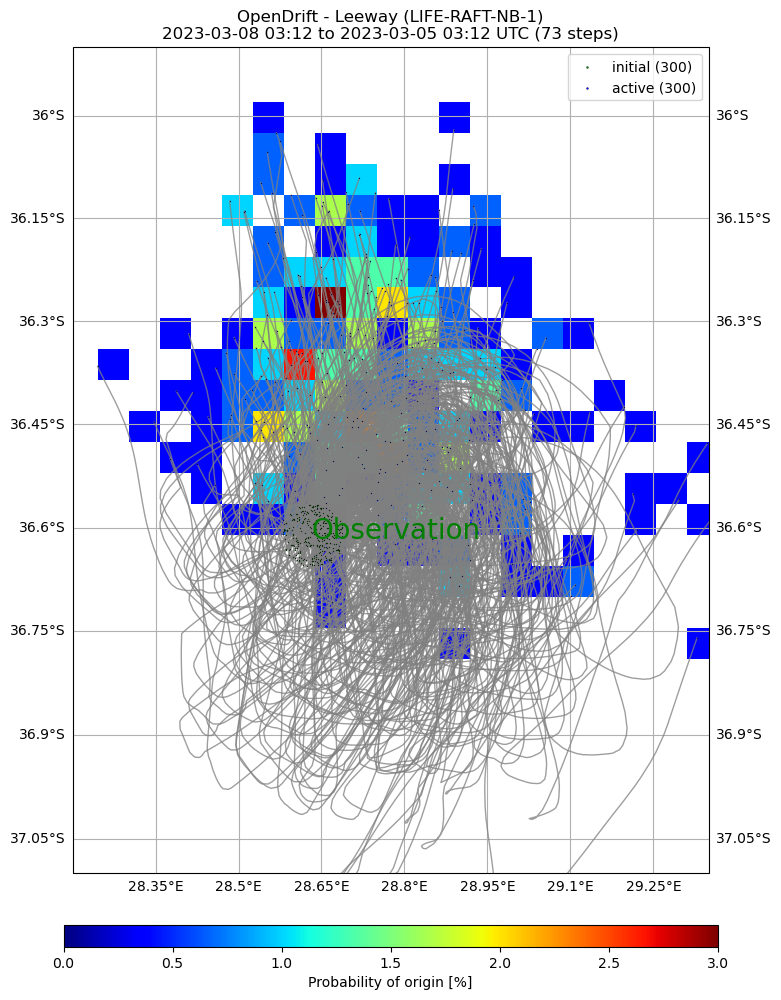

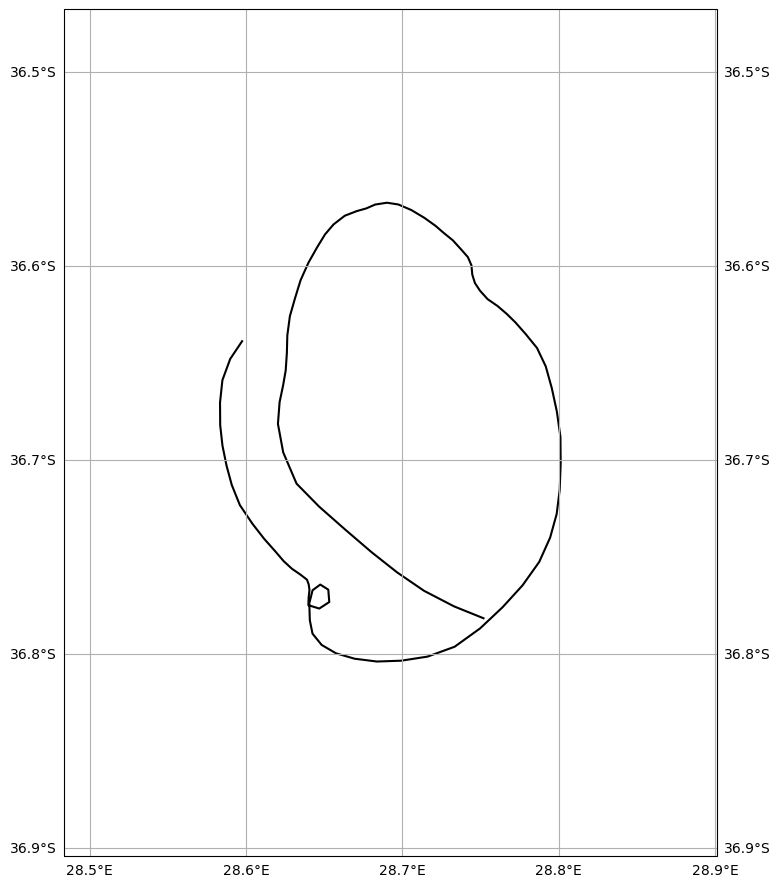

In [100]:
#o.seed_elements(lon=ilon, lat=ilat, radius=5000, radius_type='uniform', number=30000,
#                 time=end_time, object_type=object_type)
orev.seed_elements(lon=ilon, lat=ilat, radius=5000, radius_type='uniform', number=300,
                 time=end_time, object_type=object_type)
orev.run(duration=duration, time_step=-900, time_step_output=3600, outfile=outfile)
od = opendrift.open_xarray(outfile)
density_backwards = od.get_histogram(pixelsize_m=5000).isel(time=-1).isel(origin_marker=0)
density_backwards = density_backwards.where(density_backwards>0)
density_backwards = density_backwards/density_backwards.sum()*100
vmax = density_backwards.max()

plt.figure()

orev.plot(background=density_backwards, clabel='Probability of origin [%]', text=text, corners=corners, fast=True, markersize=.5, lalpha=.02, vmin=0, vmax=vmax)
d03.sel(time=slice('2023-03-05', '2023-03-08')).traj.plot(color='black')
#os.remove(path+outfile)

Try to use the "initial" locations from the reverse drift as initial locations for a forward run. 



In [102]:
outfile = 'D:/backtrack/agulhas_test9_forward.nc'
try:
    os.remove(outfile)
except:
    print("No such file")

No such file


In [103]:
lonrev, latrev = orev.get_lonlats()
loninit = np.tile(lonrev[:,-1],(10,1))
latinit = np.tile(latrev[:,-1],(10,1))

# TODO: multiply these 300 to 30000 particles randomly scattered about each of the original points with given radius
orevfwd = Leeway(loglevel=50)
orevfwd.add_reader([reader_globcur, reader_wind])
orevfwd.seed_elements(lon=loninit, lat=latinit, radius=500.0, radius_type='gaussian', 
                 time=start_time, object_type=object_type)
orevfwd.run(duration=duration, time_step=900, time_step_output=3600, outfile=outfile)
#print(orevfwd)


12:56:53 DEBUG   opendrift.models.basemodel:618: Adding 17 config items from basemodel
12:56:53 DEBUG   opendrift.models.basemodel:618: Adding 4 config items from basemodel
12:56:53 DEBUG   opendrift.models.basemodel:618: Adding 10 config items from basemodel
12:56:54 INFO    opendrift.models.basemodel:532: OpenDriftSimulation initialised (version 1.10.5)
12:56:54 DEBUG   opendrift.models.basemodel:618: Adding 2 config items from leeway
12:56:54 DEBUG   opendrift.models.basemodel:630:   Overwriting config item seed:jibe_probability
12:56:54 DEBUG   opendrift.export.io_netcdf:267: Importing from D:/backtrack/agulhas_test9_forward.nc
12:56:54 DEBUG   opendrift.models.basemodel:2449: No elements to deactivate
12:56:54 DEBUG   opendrift.export.io_netcdf:365: Setting imported config: general:use_auto_landmask -> True
12:56:54 DEBUG   opendrift.export.io_netcdf:365: Setting imported config: general:coastline_action -> stranding
12:56:54 DEBUG   opendrift.export.io_netcdf:365: Setting importe

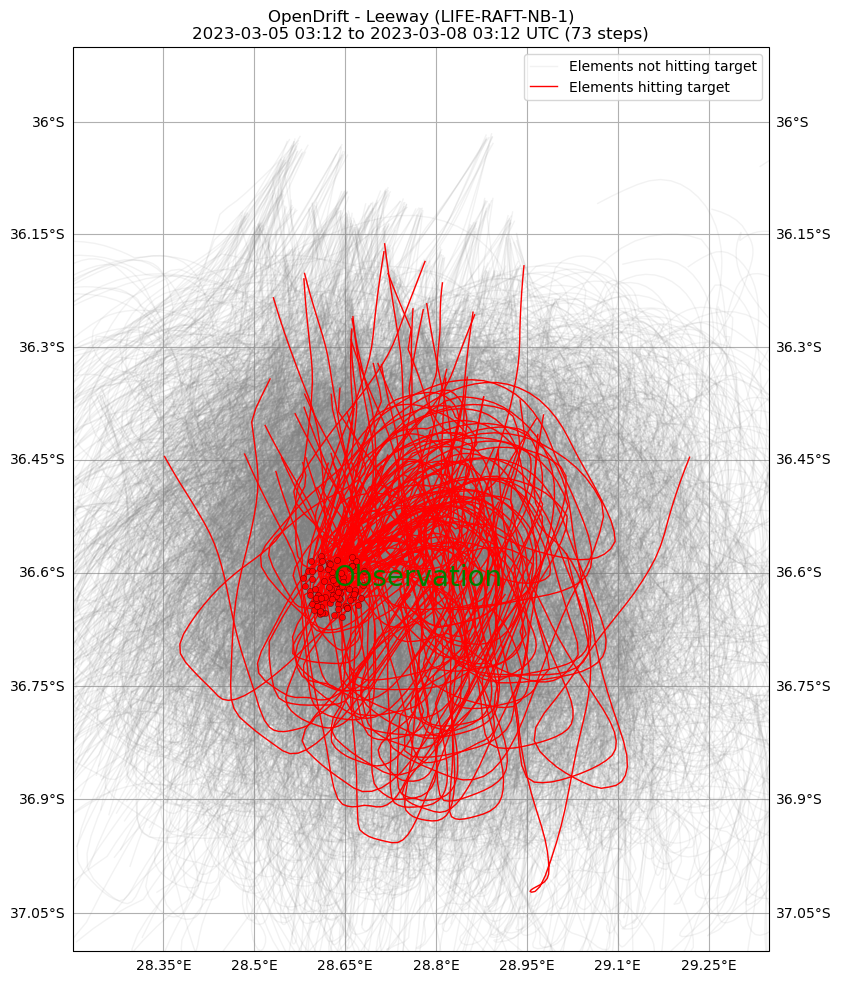

(<GeoAxes: title={'center': 'OpenDrift - Leeway (LIFE-RAFT-NB-1)\n2023-03-05 03:12 to 2023-03-08 03:12 UTC (73 steps)'}>,
 <Figure size 847.399x1100 with 1 Axes>)

In [104]:
lon, lat = orevfwd.get_lonlats()
lonend = lon[:, -1]
latend = lat[:, -1]
geod = pyproj.Geod(ellps='WGS84')
on = np.ones(lonend.shape)
dummy1, dummy2, dist2incident = geod.inv(lonend, latend, ilon*on, ilat*on)
hits = np.where(dist2incident<5000)[0]
hit_start_lons = lon[hits, 0]
hit_start_lats = lat[hits, 0]
o_hit = opendrift.open(outfile, elements=hits)

#orevfwd.animation(compare=o_hit, legend=['Elements not hitting target', 'Elements hitting target'], fast=True, corners=corners, text=text)
orevfwd.plot(compare=o_hit, legend=['Elements not hitting target', 'Elements hitting target'], show_elements=False, fast=True, corners=corners, text=text)

15:01:42 DEBUG   opendrift.models.basemodel:618: Adding 17 config items from basemodel
15:01:42 DEBUG   opendrift.models.basemodel:618: Adding 4 config items from basemodel
15:01:42 DEBUG   opendrift.models.basemodel:618: Adding 10 config items from basemodel
15:01:43 INFO    opendrift.models.basemodel:532: OpenDriftSimulation initialised (version 1.10.5)
15:01:43 DEBUG   opendrift.models.basemodel:618: Adding 2 config items from leeway
15:01:43 DEBUG   opendrift.models.basemodel:630:   Overwriting config item seed:jibe_probability
15:01:43 DEBUG   opendrift.export.io_netcdf:216: Importing with Xarray from D:/backtrack/agulhas_test9_forward.nc
15:01:43 INFO    opendrift:118: Returning <class 'opendrift.models.leeway.Leeway'> object
15:01:43 INFO    opendrift.models.basemodel:4646: 	calculating for origin_marker 0...
15:01:43 DEBUG   opendrift.models.basemodel:3163: Setting up map: corners=[28.2, 29.350000000000016, -37.1, -35.90000000000007], fast=True, lscale=None
15:01:43 WARNING ope

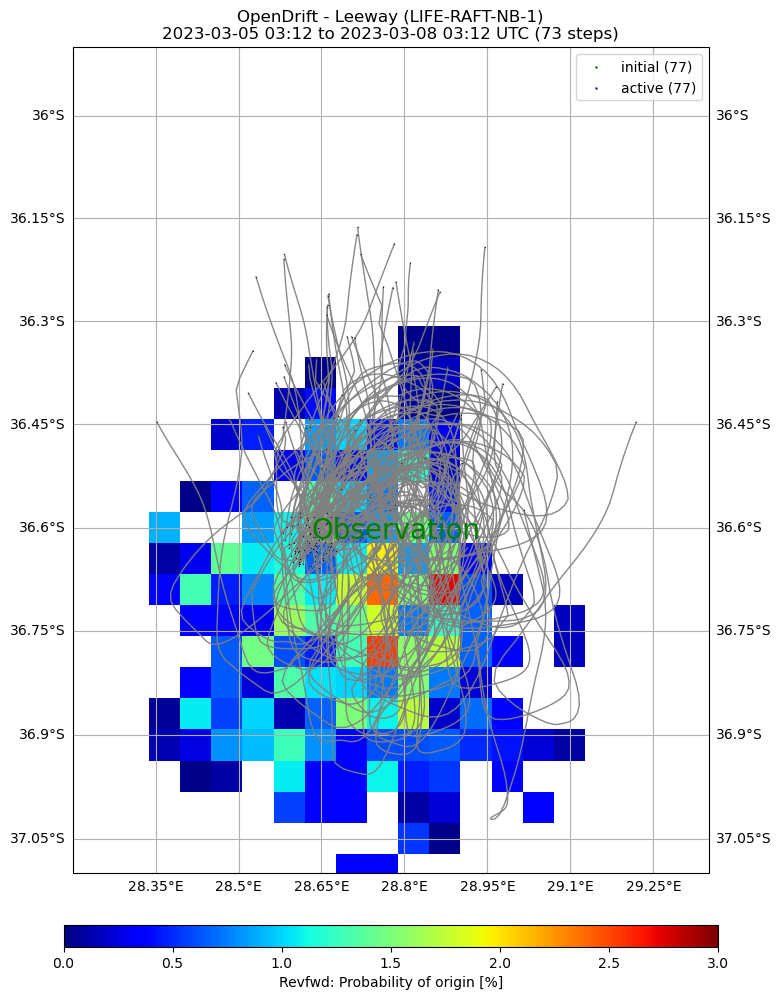

(<GeoAxes: title={'center': 'OpenDrift - Leeway (LIFE-RAFT-NB-1)\n2023-03-05 03:12 to 2023-03-08 03:12 UTC (73 steps)'}>,
 <Figure size 847.399x1100 with 2 Axes>)

In [105]:
orf = opendrift.open_xarray(outfile)#, elements=hits)             #!!!!!! THIS IS WEIRD !!!!!!

density_revfwd = orf.get_histogram(pixelsize_m=5000).isel(time=0).isel(origin_marker=0)
density_revfwd = density_revfwd.where(density_revfwd>0)
o_hit.plot(background=density_revfwd/density_revfwd.sum()*100, clabel='Revfwd: Probability of origin [%]', text=text, corners=corners, fast=True, markersize=.5, lalpha=.02, vmin=0, vmax=vmax)

In [112]:
opendrift.open_xarray(outfile, elements=None)

TypeError: open_xarray() got an unexpected keyword argument 'elements'

Simulating forward, starting at a uniform grid 24 hours earlier (440 x 320 = 140800 elements at ~500m separation)




In [122]:
outfile = 'D:/backtrack/agulhas_test9_forward_uniform.nc'
try:
    os.remove(outfile)
except:
    print("No such file")

No such file


In [123]:
ofwd = Leeway(loglevel=50)
ofwd.add_reader([reader_globcur, reader_wind])
ofwd.seed_elements(lon=lons, lat=lats, radius=0,
                 time=start_time, object_type=object_type)
try:
    os.remove(outfile)
except:
    print("No such file")
ofwd.run(duration=duration, time_step=900, time_step_output=3600, outfile=outfile)
#print(ofwd)

No such file


Finding the elements actually hitting the target (within 5 km) after 24 hours:



In [124]:
lon, lat = ofwd.get_lonlats()
lonend = lon[:, -1]
latend = lat[:, -1]
geod = pyproj.Geod(ellps='WGS84')
on = np.ones(lonend.shape)
dummy1, dummy2, dist2incident = geod.inv(lonend, latend, ilon*on, ilat*on)
hits = np.where(dist2incident<5000)[0]
hit_start_lons = lon[hits, 0]
hit_start_lats = lat[hits, 0]
o_hit = opendrift.open(outfile, elements=hits)

#ofwd.animation(compare=o_hit, legend=['Elements not hitting target', 'Elements hitting target'], fast=True, corners=corners, text=text)

15:10:53 DEBUG   opendrift.models.basemodel:618: Adding 17 config items from basemodel
15:10:53 DEBUG   opendrift.models.basemodel:618: Adding 4 config items from basemodel
15:10:53 DEBUG   opendrift.models.basemodel:618: Adding 10 config items from basemodel
15:10:53 INFO    opendrift.models.basemodel:532: OpenDriftSimulation initialised (version 1.10.5)
15:10:53 DEBUG   opendrift.models.basemodel:618: Adding 2 config items from leeway
15:10:53 DEBUG   opendrift.models.basemodel:630:   Overwriting config item seed:jibe_probability
15:10:53 DEBUG   opendrift.export.io_netcdf:267: Importing from D:/backtrack/agulhas_test9_forward_uniform.nc
15:10:53 DEBUG   opendrift.models.basemodel:2449: No elements to deactivate
15:10:53 DEBUG   opendrift.export.io_netcdf:365: Setting imported config: general:use_auto_landmask -> True
15:10:53 DEBUG   opendrift.export.io_netcdf:365: Setting imported config: general:coastline_action -> stranding
15:10:53 DEBUG   opendrift.export.io_netcdf:365: Setting

<img src="file://gallery/animations/example_leeway_backtrack_0.gif">



15:11:07 DEBUG   opendrift.models.basemodel:3163: Setting up map: corners=[28.2, 29.350000000000016, -37.1, -35.90000000000007], fast=True, lscale=None
15:11:07 WARNING opendrift.models.basemodel:3209: Plotting fast. This will make your plots less accurate.


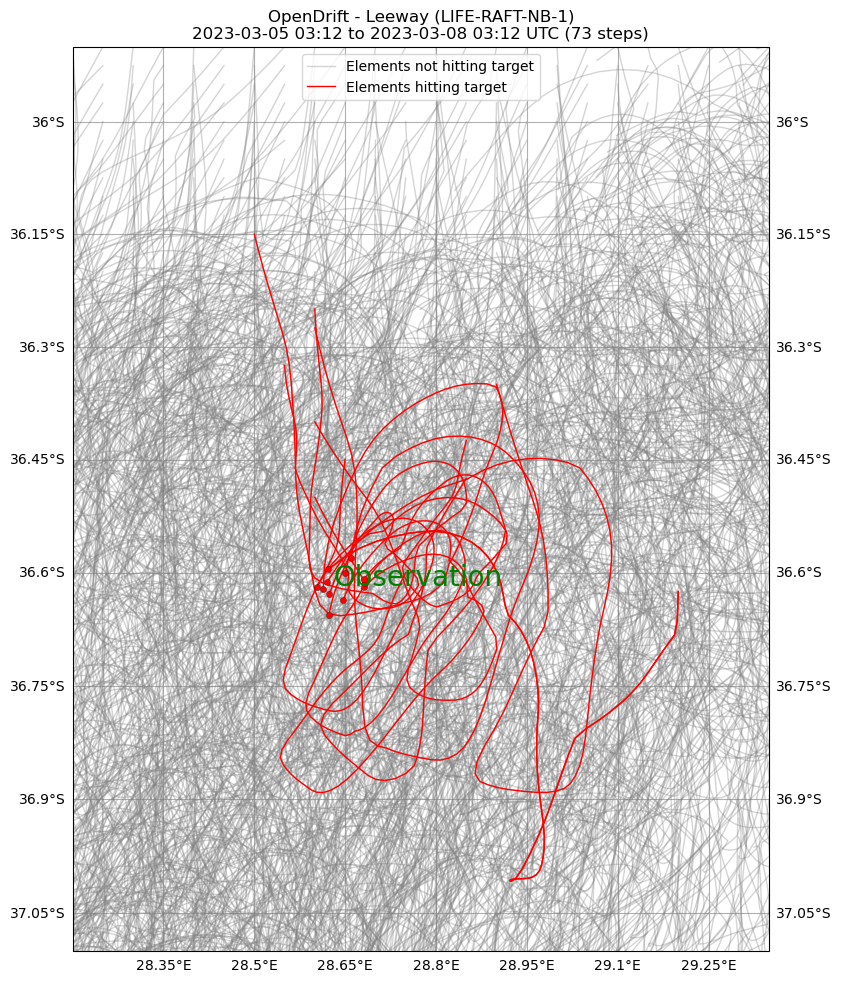

(<GeoAxes: title={'center': 'OpenDrift - Leeway (LIFE-RAFT-NB-1)\n2023-03-05 03:12 to 2023-03-08 03:12 UTC (73 steps)'}>,
 <Figure size 847.399x1100 with 1 Axes>)

In [125]:
ofwd.plot(compare=o_hit, legend=['Elements not hitting target', 'Elements hitting target'], show_elements=False, fast=True, corners=corners, text=text)

Plot the initial density of elements that actually hit the target after 24 hours. To be compared with the density figure from backwards simulation (see top)



15:11:26 DEBUG   opendrift.models.basemodel:618: Adding 17 config items from basemodel
15:11:26 DEBUG   opendrift.models.basemodel:618: Adding 4 config items from basemodel
15:11:26 DEBUG   opendrift.models.basemodel:618: Adding 10 config items from basemodel
15:11:26 INFO    opendrift.models.basemodel:532: OpenDriftSimulation initialised (version 1.10.5)
15:11:26 DEBUG   opendrift.models.basemodel:618: Adding 2 config items from leeway
15:11:26 DEBUG   opendrift.models.basemodel:630:   Overwriting config item seed:jibe_probability
15:11:26 DEBUG   opendrift.export.io_netcdf:216: Importing with Xarray from D:/backtrack/agulhas_test9_forward_uniform.nc
15:11:26 INFO    opendrift:118: Returning <class 'opendrift.models.leeway.Leeway'> object
15:11:26 INFO    opendrift.models.basemodel:4646: 	calculating for origin_marker 0...
15:11:26 DEBUG   opendrift.models.basemodel:3163: Setting up map: corners=[28.2, 29.350000000000016, -37.1, -35.90000000000007], fast=True, lscale=None
15:11:26 WAR

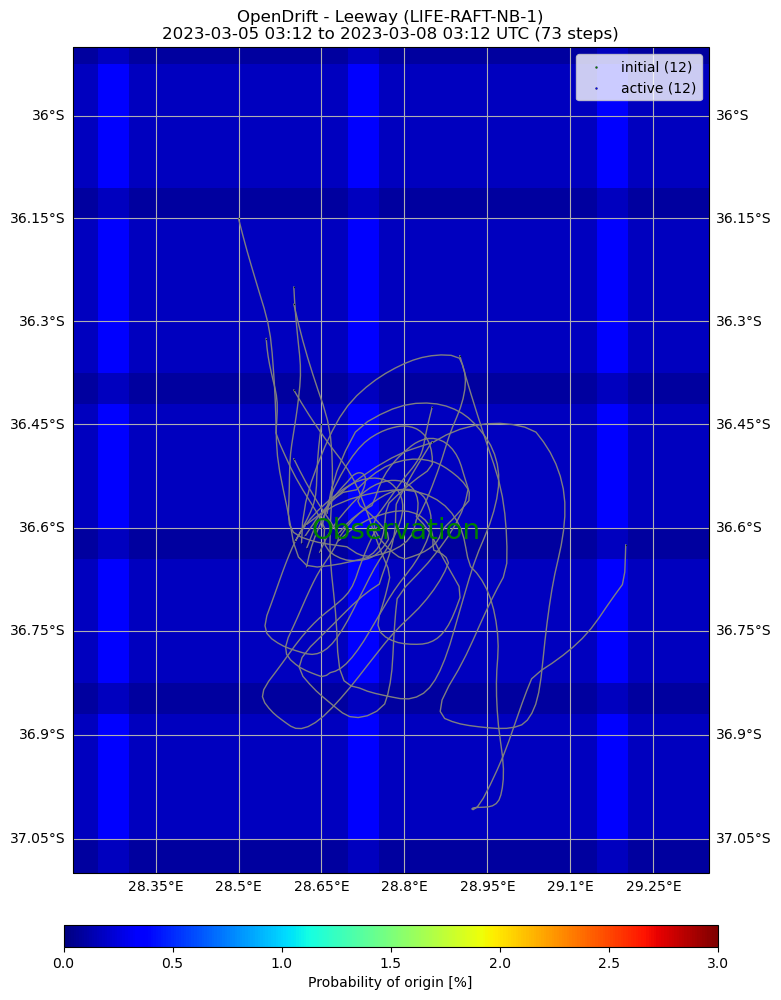

(<GeoAxes: title={'center': 'OpenDrift - Leeway (LIFE-RAFT-NB-1)\n2023-03-05 03:12 to 2023-03-08 03:12 UTC (73 steps)'}>,
 <Figure size 847.399x1100 with 2 Axes>)

In [126]:
of = opendrift.open_xarray(outfile)#, elements=hits)
#of = of(elements=hits)
density_forwards = of.get_histogram(pixelsize_m=5000).isel(time=0).isel(origin_marker=0)
density_forwards = density_forwards.where(density_forwards>0)
o_hit.plot(background=density_forwards/density_forwards.sum()*100, clabel='Probability of origin [%]', text=text, corners=corners, fast=True, markersize=.5, lalpha=.02, vmin=0, vmax=vmax)